# Часть 1. Линейная регрессия

Предположим вы выбираете автомобиль, но вы абсолютно в них не разбираетесь и хотите узнать какая цена была бы аккутуальной для той или иной модели. У нас есть файл в котором храняться данные об обявлениях о продаже автомобилях мы хотим для марки и года предсказать цену.

Будем использовать базу данных:
https://www.kaggle.com/antfarol/car-sale-advertisements/home

## 1.1. Загрузка и подготовка данных

In [44]:
import numpy as np #Библиотека numpy для работы с данными
import matplotlib.pyplot as plt #Библиотека для визуализации данных
import pandas as pd
%matplotlib inline

data=pd.read_csv('car_ad.csv')
data.head()

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68,2.5,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173,1.8,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135,5.5,Petrol,yes,2008,CL 550,rear
3,Mercedes-Benz,17800.0,van,162,1.8,Diesel,yes,2012,B 180,front
4,Mercedes-Benz,33000.0,vagon,91,NaN,Other,yes,2013,E-Class,NaN


In [48]:
mercedes_eclass = data.query('car=="Mercedes-Benz" and model=="E-Class"')

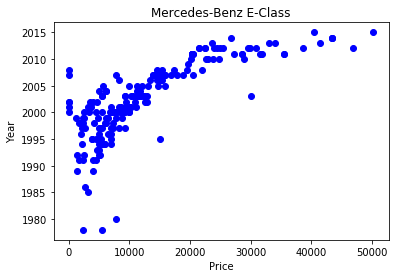

In [50]:
#Нарисуем зависимость цены от года выпуска для мерседеса E-Class
mercedes = data.query('car=="Mercedes-Benz"')
mercedes_eclass = data.query('car=="Mercedes-Benz" and model=="E-Class"')

def plot_data(x,y,marker='o', c=[0.,0.,1.],ax=None):
    if ax is None:
        mpl_fig = plt.figure()
        ax = mpl_fig.add_subplot(111)
    ax.set_title("Mercedes-Benz E-Class")
    ax.set_xlabel("Price")
    ax.set_ylabel("Year")
    ax.scatter(x,y,marker=marker,c=c)
    return ax

plot_data(mercedes_eclass['price'],mercedes_eclass['year'])

## 1.2 Математическая модель

Пусть $x$ - год выпуска, $y$ - цена

Мы хотим построить зависимость:
$y=f(x)$, чтобы для нового года выпуска предсказывать цену

Перавя наша модель будет линейной $y=ax+b$ где коэфциенты $a$ и $b$ нужно обучить

In [55]:
import torch

x = torch.from_numpy(mercedes_eclass['year'].as_matrix().astype(np.float32))
y = torch.from_numpy(mercedes_eclass['price'].as_matrix().astype(np.float32))


#Нормируем данные
x = (x-torch.mean(x))/torch.std(x)
y = (y-torch.mean(y))/torch.std(y)

#Запишем параметры модели
a = torch.FloatTensor([1.])
a.requires_grad=True # Выстатив данный флаг указывает pytorch, что для данной переменной необходимо вычислить градиенты
b = torch.FloatTensor([1.])
b.requires_grad=True

## 1.3. Функция потерь

В задаче линейной регрессии мы будем считать функцию потерь как среднеквадратичное отклонение:

$l_{a,b}(x,y)=\frac{1}{2*N}\sum(a*x_i+b-y_i)^2$

In [56]:
#Функция потерь
loss = torch.mean((a*x+b-y)**2)

## 1.4. Оптимизация функции потерь по $a$ и $b$
Напишем процедуру оптимизации функции потерь методом градиентного спуска


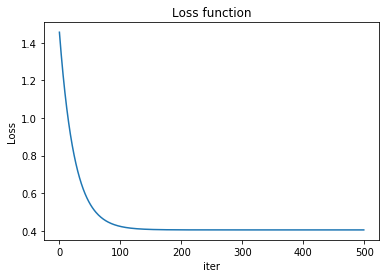

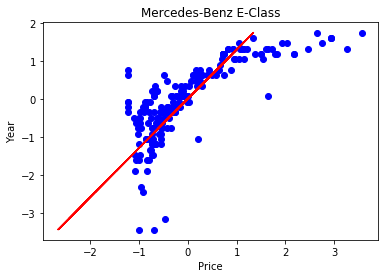

In [57]:
def plot_loss(errors):
    mpl_fig = plt.figure()
    ax = mpl_fig.add_subplot(111)
    ax.set_title("Loss function")
    ax.set_xlabel("iter")
    ax.set_ylabel("Loss")
    ax.plot(errors) 
    
errors = []

lr = 0.01 #Скорость обучения
with torch.no_grad():#Отключаем автоматическое вычисление градиентов pytorch
    a.fill_(1.)
    b.fill_(1.)
    for i in range(500):
        # Вычисляем производные по loss по параметрам a и b
        dlda = 2*torch.mean((a*x+b-y)*x)
        dldb = 2*torch.mean((a*x+b-y))
        #На самом деле вычисление функции потерь нужно для того чтобы 
        loss = torch.mean((a*x+b-y)**2)
        errors+=[loss.item()]
        #Шаг градиента
        a -= dlda*lr
        b -= dldb*lr
        
plot_loss(errors)
#Подставим получившиеся параметры в нашу модель
y_aprox = x*a+b
ax = plot_data(y,x)
ax.plot(y_aprox.detach().numpy(),x.numpy(),'r-')

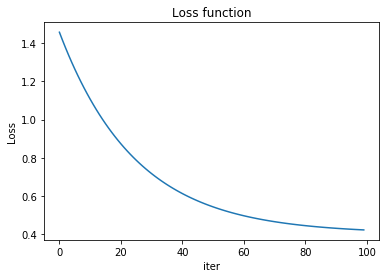

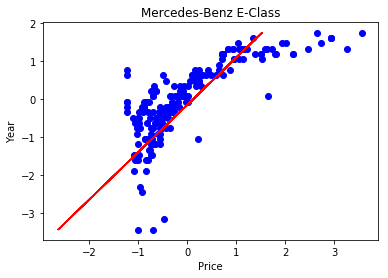

In [58]:
errors = []
with torch.no_grad():#Отключаем автоматическое вычисление градиентов pytorch для сброса параметров
    a.fill_(1.)
    b.fill_(1.)
lr = 0.01 #Скорость обучения
for i in range(100):
    #Обнулить градиенты
    if a.grad: a.grad.zero_() 
    if b.grad: b.grad.zero_() 
        
    loss = torch.mean((a*x+b-y)**2)#Вычислить значение функции потерь  
    loss.backward()#Вычислить градиенты по параметрам у ктороых стоит флаг requires_grad=True
    with torch.no_grad():#Отключаем автоматическое вычисление градиентов
        #Обновляем значения параметров модели
        a -= a.grad*lr
        b -= b.grad*lr
    errors+=[loss.item()]#Сохранить значение функции потерь

#Нарисовать функцию потерь
plot_loss(errors)
#Подставим получившиеся параметры в нашу модель
y_aprox = x*a+b
ax = plot_data(y,x)
ax.plot(y_aprox.detach().numpy(),x.numpy(),'r-')

## 1.5. Использования оптимизатора pytorch

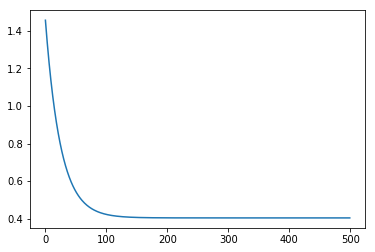

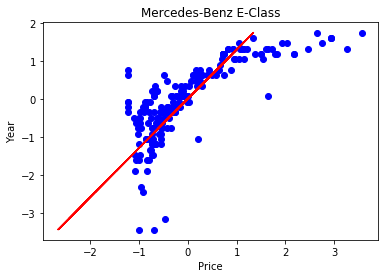

In [59]:

with torch.no_grad():#Отключаем автоматическое вычисление градиентов pytorch для сброса параметров
    a.fill_(1.)
    b.fill_(1.)
    
import torch.optim as optim
opt = optim.SGD(params=[a,b],lr=0.01)
errors = []

for i in range(500):
    opt.zero_grad()#Обнулить градиенты ОЧЕНЬ ВАЖНО!
    loss = torch.mean((a*x+b-y)**2)#Вычислить значение функции потерь  
    loss.backward()
    opt.step()
    errors+=[loss.item()]
    
    
plt.plot(errors)  
#Подставим получившиеся параметры в нашу модель
y_aprox = x*a+b
ax = plot_data(y,x)
ax.plot(y_aprox.detach().numpy(),x.numpy(),'r-')

## 1.6 Модель в стиле PyTorch
Перепишем нашу модель в стиле PyTorch с использованием вместо явного задания функции модуль torch.nn.Linear

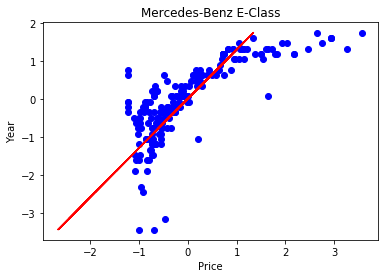

In [60]:
model = torch.nn.Linear(1,1)#Вместо a b используем класс линейного слоя нейронной сети
opt = optim.SGD(params=model.parameters(),lr=0.01)
vx = x.unsqueeze(-1)
vy = y.unsqueeze(-1)
for i in range(10000):
    loss = torch.nn.functional.mse_loss(model(vx),vy)
    loss.backward()
    opt.step()
    
y_aprox = x*a+b
ax = plot_data(y,x)
ax.plot(y_aprox.detach().numpy(),x.numpy(),'r-')

## 1.7 Полиномиальня регрессия
Что если наша текущая модель не самая аддекватная? Мы можем попробовать использобать квадратичную модель: $y = w_01 + w_1x_1 + w_2x_1^2$

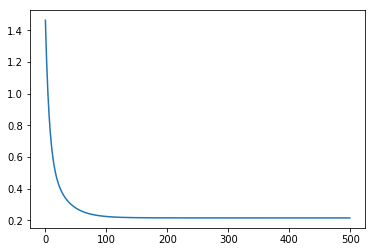

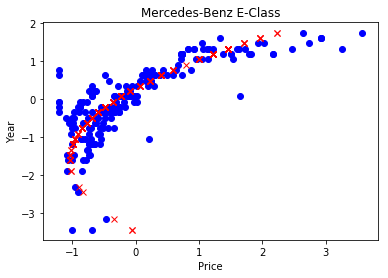

In [61]:
model = torch.nn.Linear(2,1)#Вместо a b используем класс линейного слоя нейронной сети
opt = optim.SGD(params=model.parameters(),lr=0.01)
vx = x.unsqueeze(-1)
vy = y.unsqueeze(-1)
vx2 = torch.cat([vx**2,vx],1)
errors=[]
for i in range(500):
    opt.zero_grad()
    loss = torch.nn.functional.mse_loss(model(vx2),vy)
    loss.backward()
    opt.step()
    errors+=[loss.item()]
    
    
plt.plot(errors)  
    
y_aprox = model(vx2)
ax = plot_data(y,x)
ax.plot(y_aprox.detach().numpy(),x.numpy(),'rx')

## 1.7. Пример неадекватной модели
$y=w_01+w_1x_1+w_2x_1^2+w_3x_1^3+w_4x_1^4$
Очевидно, что цена не будет падать у новых автомобилей.

torch.Size([199, 4])


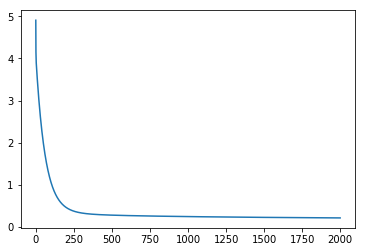

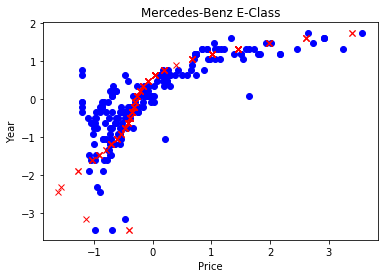

In [62]:
model = torch.nn.Linear(4,1)#Вместо a b используем класс линейного слоя нейронной сети
opt = optim.SGD(params=model.parameters(),lr=0.001)
vx = x.unsqueeze(-1)
vy = y.unsqueeze(-1)
vx2 = torch.cat([vx**4,vx**3,vx**2,vx],1)
print(vx2.shape)
errors=[]
for i in range(2000):
    opt.zero_grad()
    loss = torch.nn.functional.mse_loss(model(vx2),vy)
    loss.backward()
    opt.step()
    errors+=[loss.item()]
    
    
plt.plot(errors)  
    
y_aprox = model(vx2)
ax = plot_data(y,x)
ax.plot(y_aprox.detach().numpy(),x.numpy(),'rx')

# 2.1 Разбиение данных
Для оценки правильности работы нашего алгоритма разобъем данные на три группы: обучающая выборка (80%), валидационная выборка (10%) и тестовая выборка (10%)

* обучающая выборка (training set) на ней будем запускать алгоритм машинного обучения
* валидационная выборка (valid set) на ней будем настраивать параметры обучающего алгоритма и модели
* тестовая выборка (test set) выборка на которой мы измеряем точноть нашего метода 

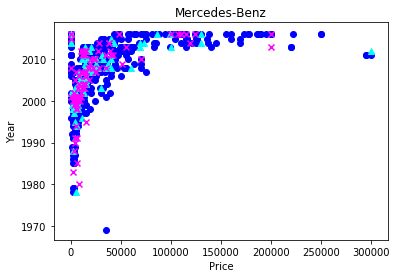

In [78]:
indexes = np.random.permutation(len(mercedes))
valid_len = test_len = len(mercedes)/10
train = mercedes.iloc[indexes[:-valid_len-test_len]]
valid = mercedes.iloc[indexes[-valid_len-test_len:-test_len]]
test = mercedes.iloc[indexes[-test_len:]]

ax = plot_data(train['price'],train['year'],marker='o', c=[0.,0.,1.])
plot_data(valid['price'],valid['year'],marker='^', c=[0.,1.,1.],ax=ax)
plot_data(test['price'],test['year'],marker='x', c=[1.,0.,1.],ax=ax)
ax.set_title("Mercedes-Benz")

## 2.1 Классификация
Мы получаем пару год, цена и хотим ответить завышена цена автомобиля или нет

In [79]:
x = torch.from_numpy(train.get(['year','price']).as_matrix().astype(np.float32))
meanx = torch.mean(x,dim=0)
stdx = torch.std(x,dim=0)
x = (x-meanx)/stdx

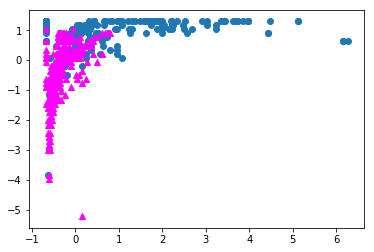

In [80]:
has_reg = np.where(train['mileage'].as_matrix().astype(np.float32)<100)
plt.scatter(x[has_reg,1],x[has_reg,0])
no_reg = np.where(train['mileage'].as_matrix().astype(np.float32) >=100)
plt.scatter(x[no_reg,1],x[no_reg,0],marker='^', c=[1.,0.,1.])

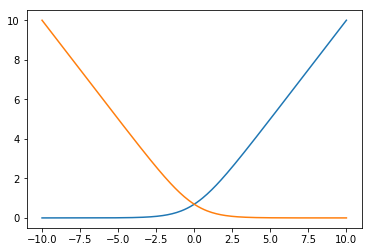

In [81]:
def sigmoid(x):
    return 1./(1.+np.exp(-x))

def bce(x,y):
    return -y*np.log(sigmoid(x))-(1-y)*np.log(1-sigmoid(x))

x = np.linspace(-10.,10.,200)
plt.plot(x,bce(x,0))
plt.plot(x,bce(x,1))

torch.Size([737, 2])


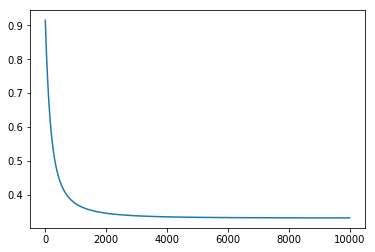

In [82]:
#Добавлем сигмоиду в нашу модель вычислений
model = torch.nn.Sequential(torch.nn.Linear(2,1),torch.nn.Sigmoid())


x = torch.from_numpy(train.get(['year','price']).as_matrix().astype(np.float32))
#Нормируем данные
meanx = torch.mean(x,dim=0)
stdx = torch.std(x,dim=0)
x = (x-meanx)/stdx

y = torch.from_numpy((train['mileage'].as_matrix().astype(np.float32)<100).astype(np.float32))


opt = optim.SGD(params=model.parameters(),lr=0.01)
print(x.shape)
vx = x
vy = y.unsqueeze(-1)
errors=[]
for i in range(10000):
    
    opt.zero_grad()
    v = model(vx)
    loss = torch.nn.functional.binary_cross_entropy(v,vy)
    loss.backward()
    opt.step()
    errors+=[loss.item()]
    
plt.plot(errors)  

In [83]:
valid_x = torch.from_numpy(valid.get(['year','price']).as_matrix().astype(np.float32))
valid_x = (valid_x-meanx)/stdx
y_aprox = model(valid_x)
y_true =torch.from_numpy((valid['mileage'].as_matrix().astype(np.float32)<100).astype(np.float32))

In [84]:
def confusion(prediction, truth):
    confusion_vector = prediction / truth

    true_positives = torch.sum(confusion_vector == 1).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

print(confusion((y_aprox[:,0]>0.5).float(),y_true.float()))

(16, 3, 69, 4)


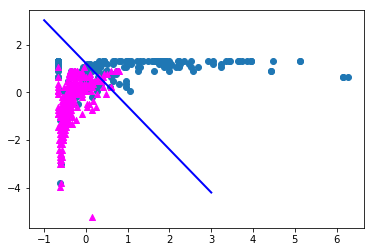

In [87]:
new_car = np.where(train['mileage'].as_matrix().astype(np.float32)<100)
plt.scatter(x[new_car,1],x[new_car,0])
not_new_car = np.where(train['mileage'].as_matrix().astype(np.float32) >=100)
plt.scatter(x[not_new_car,1],x[not_new_car,0],marker='^', c=[1.,0.,1.])

def get_x2(x1,w0,w1,w2):
    return -(w1*x1+w0)/w2

x1 = np.linspace(-1,3)
w0=model[0].bias.item()
w1 = model[0].weight[0,0].item()
w2 = model[0].weight[0,1].item()
plt.plot(x1, get_x2(x1,w0,w1,w2), color='b', linestyle='-', linewidth=2)

# 3.2. Multiclass classififcation

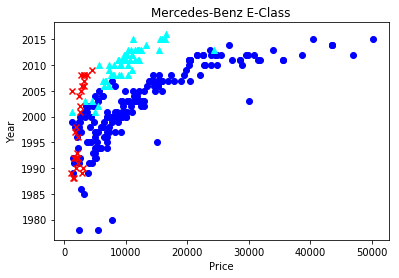

In [120]:
mercedes_eclass = data.query('car=="Mercedes-Benz" and model=="E-Class" and price>0 and engV !="NaN"')
ford_focus = data.query('car=="Ford" and model=="Focus" and price>0 and engV !="NaN"')
vaz_2109 = data.query('car=="VAZ" and model=="2109" and price>0 and engV !="NaN"')

ax = plot_data(mercedes_eclass['price'],mercedes_eclass['year'],marker='o', c=[0.,0.,1.])
plot_data(ford_focus['price'],ford_focus['year'],marker='^', c=[0.,1.,1.],ax=ax)
plot_data(vaz_2109['price'],vaz_2109['year'],marker='x', c=[1.,0.,0.],ax=ax)

In [131]:
all_data = pd.concat([mercedes_eclass,ford_focus,vaz_2109])
indexes = np.random.permutation(len(all_data))
valid_len = test_len = len(all_data)/10
train = all_data.iloc[indexes[:-valid_len-test_len]]
valid = all_data.iloc[indexes[-valid_len-test_len:-test_len]]
test = all_data.iloc[indexes[-test_len:]]

In [154]:
x = torch.from_numpy(train.get(['year','price','mileage','engV']).as_matrix().astype(np.float32))
#Нормируем данные
meanx = torch.mean(x,dim=0)
stdx = torch.std(x,dim=0)
x = (x-meanx)/stdx

#y = torch.from_numpy((train['mileage'].as_matrix().astype(np.float32)<100).astype(np.float32))

In [156]:
def one_hot(data,classes):
    onehot = np.zeros((len(data),len(classes)))
    for idx,car in enumerate(data['car']):
        x = classes.index(car)
        onehot[idx,x]=1
    return onehot

def cat(data,classes):
    onehot = np.zeros((len(data)))
    for idx,car in enumerate(data['car']):
        onehot[idx]=classes.index(car)
    return onehot

cat(train,['Mercedes-Benz','VAZ','Ford'])

array([1., 0., 2., 0., 2., 0., 2., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 2., 2., 2., 0.,
       0., 0., 0., 0., 2., 2., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 2., 2., 0., 2., 0., 0., 0., 0., 0., 0., 2., 2.,
       0., 0., 0., 1., 0., 0., 2., 0., 1., 2., 2., 0., 0., 0., 0., 0., 2.,
       0., 2., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 2., 2., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 2., 0., 1., 2., 0., 2., 2., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       2., 0., 2., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 2., 0.])

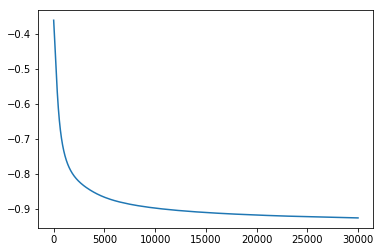

In [213]:
model = torch.nn.Sequential(torch.nn.Linear(4,3))
#model = torch.nn.Sequential(torch.nn.Linear(4,4),torch.nn.ReLU(),torch.nn.Linear(4,3))
opt = optim.SGD(params=model.parameters(),lr=0.01)

vx = x
y = torch.from_numpy(cat(train,['Mercedes-Benz','VAZ','Ford'])).long()
vy = y
errors=[]
for i in range(30000):
    
    opt.zero_grad()
    v = model(vx)
    v = torch.nn.functional.softmax(v,dim=1)
    loss = torch.nn.functional.nll_loss(v,vy)
    loss.backward()
    opt.step()
    errors+=[loss.item()]
    
plt.plot(errors)  

In [214]:
valid_x = torch.from_numpy(valid.get(['year','price','mileage','engV']).as_matrix().astype(np.float32))
#Нормируем данные
valid_x = (valid_x-meanx)/stdx

In [218]:
probs = model(valid_x)
print(np.argmax(probs.detach(),axis=1))
print(cat(valid,['Mercedes-Benz','VAZ','Ford']))
print(np.sum(np.argmax(probs.detach(),axis=1).numpy()==cat(valid,['Mercedes-Benz','VAZ','Ford']))/float(len(valid_x)))

tensor([ 2,  0,  2,  0,  0,  1,  1,  0,  2,  0,  2,  0,  0,  0,
         0,  0,  0,  1,  0,  0,  0,  2,  2,  0,  0,  0,  0])
[2. 0. 2. 0. 0. 1. 1. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 2. 2. 0.
 0. 0. 0.]
0.9629629629629629


In [180]:
torch.nn.functional.softmax(probs.detach())

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


tensor([[ 1.6697e-04,  3.7486e-03,  9.9608e-01],
        [ 9.9934e-01,  2.4848e-04,  4.1083e-04],
        [ 6.3106e-04,  3.2390e-03,  9.9613e-01],
        [ 9.9990e-01,  5.2310e-05,  4.8019e-05],
        [ 9.9967e-01,  3.2723e-05,  2.9949e-04],
        [ 5.5898e-02,  8.9436e-01,  4.9745e-02],
        [ 2.3561e-03,  9.6173e-01,  3.5911e-02],
        [ 9.9999e-01,  9.0398e-07,  7.6335e-06],
        [ 2.3031e-05,  1.7768e-03,  9.9820e-01],
        [ 9.9985e-01,  2.8611e-05,  1.2465e-04],
        [ 1.4819e-03,  1.3396e-02,  9.8512e-01],
        [ 9.8120e-01,  4.7895e-03,  1.4013e-02],
        [ 6.9318e-01,  4.5076e-02,  2.6174e-01],
        [ 1.0000e+00,  4.4881e-11,  4.7655e-11],
        [ 9.9997e-01,  5.8277e-06,  2.7110e-05],
        [ 9.9909e-01,  3.0290e-05,  8.8265e-04],
        [ 1.0000e+00,  2.4147e-06,  2.1169e-06],
        [ 1.3284e-01,  5.4301e-01,  3.2414e-01],
        [ 9.9999e-01,  5.4691e-06,  7.6145e-07],
        [ 9.9614e-01,  4.3015e-04,  3.4333e-03],
        [ 1.0000e+00